# Sales Insights From The Northwind Traders Database

<span style="color:indigo">By Valentina Fontiveros</span>


<img src="banner$.png">

### Introduction

The Northwind Traders database is a fictional database created by Microsoft.

The goal of this project is to extract information and test various hypotheses.
For reference, here is the database ERD.

<img src="Northwind_ERD_Updated.png">

### Import Libraries

In [24]:
import pandas as pd
from sqlalchemy import *
from sqlalchemy.ext.automap import automap_base
import numpy as np 
import matplotlib.pyplot as plt
from pprint import pprint
from scipy import stats
import seaborn as sns

### Connect to SQL Database

In [25]:
engine = create_engine('sqlite:///Northwind_small.sqlite')
conn = engine.connect()

### Question 1: Does Discount Level Have an Effect on Quantity Sold?

The purpose of a discount is often to encourage bulk orders. Is this supported by the facts at Northwind Traders?

#### Exploratory Data Analysis

In [26]:
# Query SQL Database
query = """
SELECT 
    p.ProductName, od.UnitPrice, od.Quantity, od.Discount
FROM 
    Product p
    JOIN
    OrderDetail od
    ON 
    p.Id = od.ProductId
ORDER BY
    p.ProductName
"""
df = pd.read_sql_query(query, engine)


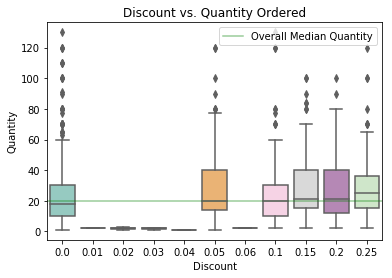

In [27]:
# Visualize Order Quantity 
sns.boxplot(df.Discount,df.Quantity, palette = "Set3")
ax = sns.lineplot(x= range(-3,25), y= np.median(df.Quantity),alpha=0.4,color='green',label='Overall Median Quantity')
#ax2 = sns.lineplot(x= range(-3,25), y= np.mean(df.Quantity),alpha =0.4,color='indigo',label='Overall Mean Quantity')
plt.title('Discount vs. Quantity Ordered')
plt.show()

Qualitative observation: Median Quantity Ordered doesn't change much until the discount reaches 25%

Overall Mean Quantity Ordered is visually affected by outliers.

#### Data Cleanup / Grouping

In [28]:
# data clean up and grouping into discount brackets

# Get rid of Discounts betweeen 0.01 and 0.04, and 0.06
no_disc = df[df.Discount == 0]
disc5 = df[df.Discount == 0.05]
disc10 = df[df.Discount == 0.10]
disc15 = df[df.Discount == 0.15]
disc20 = df[df.Discount == 0.20]
disc25 = df[df.Discount == 0.25]

disc_all = [no_disc,disc5,disc10,disc15,disc20,disc25]

# store values on a dataframe
#for d in disc_all:
   # d['Total_Orders'] = len(d)
   # d['Total_Orders_Quantity'] = np.sum(d.Quantity)
df = pd.concat(disc_all)

#### Statistical Analysis

Hypothesis:
> Null: Discount level has no effect on the mean quantity sold.

> Alternative: Discount level has a significant effect on the mean quantity sold. (Two-tailed test)

In [29]:
def tstats(series1,series2,iterations): #series 1 should have least amount of entries
    pvals = []
    for i in range(iterations):
        sample1 = np.random.choice(series1,size = len(series1/2))
        sample2 = np.random.choice(series2,size= len(series1/2))
        # Calculate T statistic and p-value
        t = stats.ttest_ind(sample1, sample2)
        pvals.append(t[1])
    return sample1,sample2,pvals

In [30]:
def plotKDE(sample1,sample2,dep_var_name,s1_name,s2_name):
    plt.hist(sample1, alpha=0.4, color = 'green',label=s1_name, density=True)
    plt.hist(sample2, alpha=0.4, color = 'indigo', label= s2_name, density=True)
    sns.kdeplot(sample1,color = 'green')
    sns.kdeplot(sample2,color = 'indigo')
    plt.title('Probability Density Function')
    plt.xlabel(str(dep_var_name))
    plt.ylabel('Probability')
    plt.legend()
    plt.show()
    print(stats.ttest_ind(sample1, sample2))


In [31]:
def plotpval(p_vals):
    plt.hist(p_vals, range=(0,np.max(p_vals)),bins=50,color='green',alpha=0.4)
    plt.xlabel('P values')
    plt.ylabel('Frequency')
    plt.title('P-values')
    plt.show()
    print('Mean p-value for all experiments: ' + str(np.mean(p_vals)))

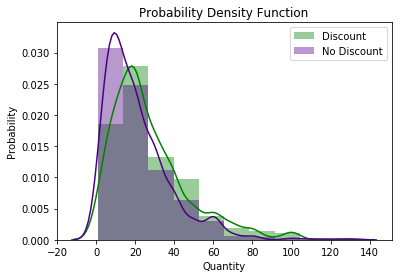

Ttest_indResult(statistic=6.9319649232281755, pvalue=5.923489833026313e-12)


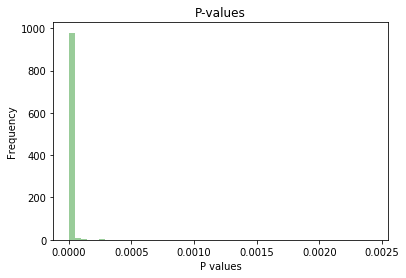

Mean p-value for all experiments: 7.991190951274592e-06


In [32]:
# discount / no discount
series1 = df[df.Discount > 0].Quantity
series2 = no_disc.Quantity

s1,s2,ps = tstats(series1,series2,1000)
plotKDE(s1,s2,'Quantity','Discount','No Discount')
plotpval(ps)

#### Finding 1:
Quantity ordered is significantly altered when the product is discounted. 

Mean p-value: 7.99e-6

#### No Discount Vs. Discount Levels

### Question 2: Which discount levels (5% thru 25%) have an effect on the quantity ordered?

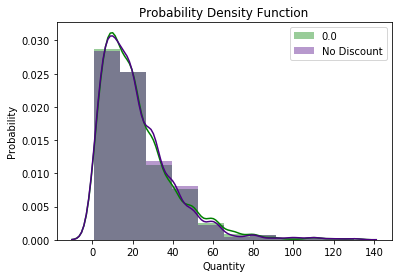

Ttest_indResult(statistic=0.5448827272476682, pvalue=0.5858803408681066)


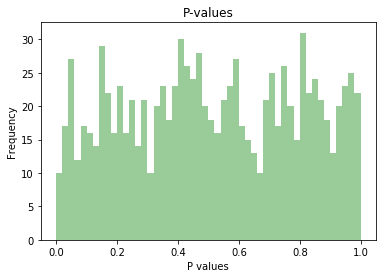

Mean p-value for all experiments: 0.51375468121133


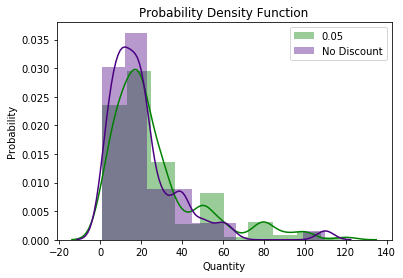

Ttest_indResult(statistic=2.6959269386251545, pvalue=0.007341625616663962)


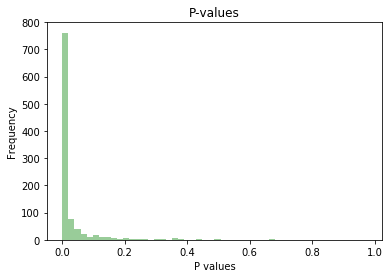

Mean p-value for all experiments: 0.031008515617013996


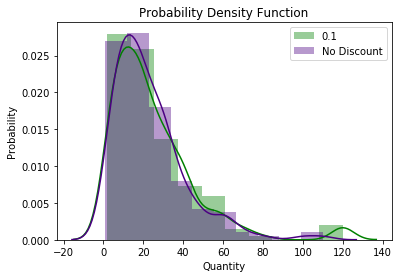

Ttest_indResult(statistic=0.8137441865203018, pvalue=0.4163544100691433)


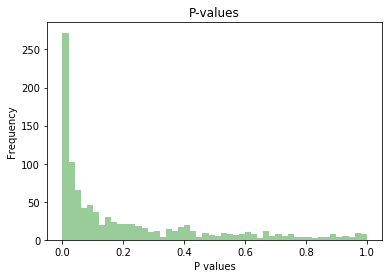

Mean p-value for all experiments: 0.2060800729166988


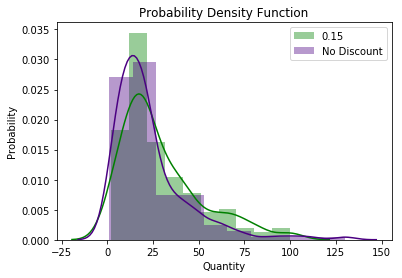

Ttest_indResult(statistic=2.475136335750811, pvalue=0.013849474962214831)


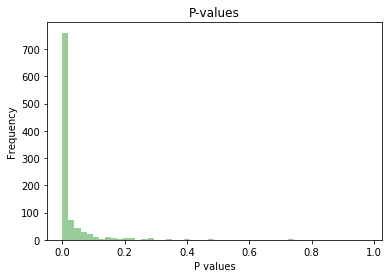

Mean p-value for all experiments: 0.029118154566379843


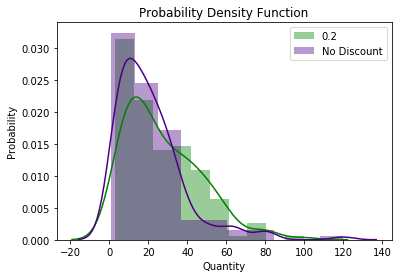

Ttest_indResult(statistic=3.102853859734892, pvalue=0.002087526514557801)


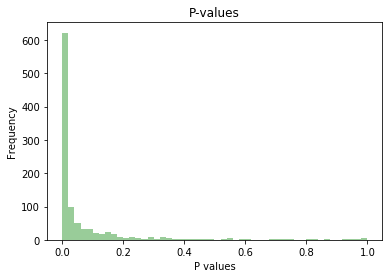

Mean p-value for all experiments: 0.06203402795493025


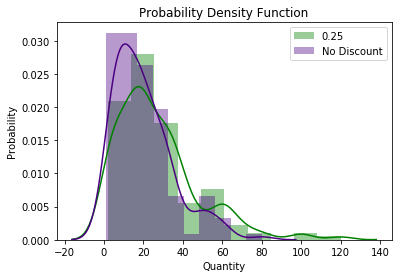

Ttest_indResult(statistic=3.406643105950765, pvalue=0.0007455868490117763)


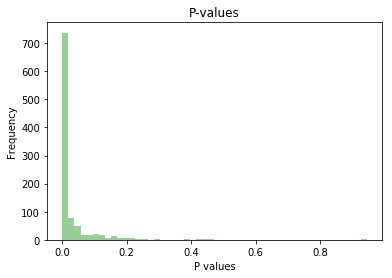

Mean p-value for all experiments: 0.03234637161973299


In [33]:
# discount / no discount
for d in disc_all:
    series1 = d.Quantity
    series2 = no_disc.Quantity
    sample1, sample2, p_values = tstats(series1,series2,1000)
    plotKDE(sample1,sample2,'Quantity',str(d.Discount.iloc[0]),'No Discount')
    plotpval(p_values)

#### Finding 2:

> 5%, 15%, and 25% discounts have p values < 0.05
> 10% and 20% discounts have p values > 0.05

Thus, not all discount levels are statistically impactful on order quantity. 
Order quantity increases for 5%, 15%, and 25% discount levels.

### Question 3: Are products purchased priced differently when shipped to America vs. Europe?

> Null Hypothesis: Shipping Destination (to Europe or America) has no effect on price.

> Alternate Hypothesis: Shipping Destination has an effect on price (two-tailed test).

In [34]:
# Extract information from the database
query = """
SELECT c.Region, o.Id, od.UnitPrice
FROM Customer c, [Order] o, OrderDetail od
WHERE c.Id = o.CustomerID AND
od.OrderID = o.Id
"""
df = pd.read_sql_query(query, engine)


In [35]:
eur = ['Western Europe','Eastern Europe','Northern Europe','Southern Europe']
amer = ['South America','Central America','North America']
europe = df[df.Region.isin(eur)].UnitPrice
america = df[df.Region.isin(amer)].UnitPrice

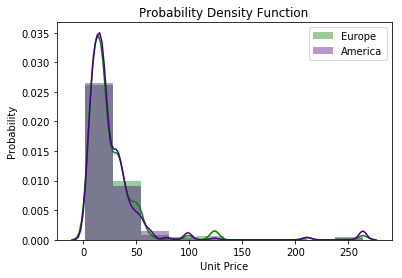

Ttest_indResult(statistic=-0.2513710019415551, pvalue=0.8015523328657643)


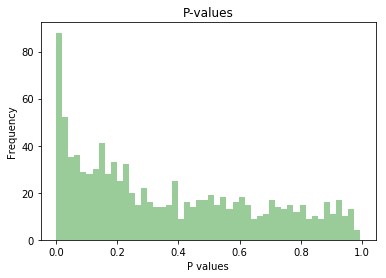

Mean p-value for all experiments: 0.36255219927140486


In [36]:
s1,s2,ps = tstats(europe,america,1000)
plotKDE(s1,s2,'Unit Price','Europe','America')
plotpval(ps)

#### Findings 3:

> The unit prices for products sold in Europe and America are essentially not different.

> Therefore, we cannot reject the null hypothesis. P-value > 0.05.

### Question 4: Are products shipped to North America priced differently than those shipped to South America?

> Null Hypothesis: Shipping Destination (to South Ameirca or North America) has no effect on price.

> Alternate Hypothesis: Shipping Destination has an effect on price (two-tailed test).

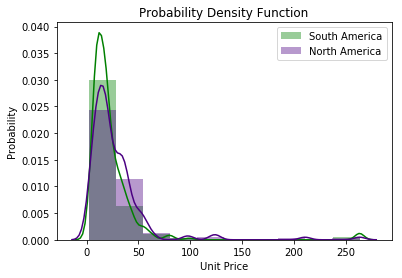

Ttest_indResult(statistic=-1.5737894906299688, pvalue=0.11605803071781946)


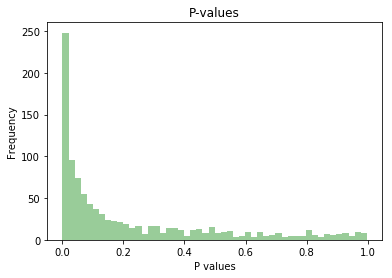

Mean p-value for all experiments: 0.21902729748081054


In [37]:
south = df[df.Region == 'South America'].UnitPrice
north = df[df.Region == 'North America'].UnitPrice

s1,s2,ps = tstats(south,north,1000)
plotKDE(s1,s2,'Unit Price','South America','North America')
plotpval(ps)


#### Finding 4:

> The unit prices for products sold in North and South America are essentially not different.

> Cannot reject the null hypothesis!

### Question 5:  Does Delivery Destination Impact Whether Delivery is On Time?

> Null Hypothesis: Delivery Destination does not have an effect on on-time deliveries

> Alternate Hypothesis: Delivery Destination has an effect on on-time deliveries.

In [38]:
# Query the SQL Database
query = """
SELECT c.Region, o.RequiredDate, o.ShippedDate
FROM Customer c, [Order] o
WHERE c.Id = o.CustomerID 
"""
# store results in a dataframe
df = pd.read_sql_query(query, engine)

In [39]:
# clean up some data
df.ShippedDate.fillna('2000-01-01',inplace=True)

# Create a new field, which represents days before shipment
from datetime import datetime
delta = []
for i in range(len(df.ShippedDate)):
    date_format = "%Y-%m-%d"
    a = datetime.strptime(df.ShippedDate.iloc[i], date_format)
    b = datetime.strptime(df.RequiredDate.iloc[i], date_format)
    delta.append((b - a).days)

df['Delta'] = delta
df = df[df.Delta<100]

# preview results
df.head()

,Region,RequiredDate,ShippedDate,Delta
0,Western Europe,2012-08-01,2012-07-16,16
1,Western Europe,2012-08-16,2012-07-10,37
2,South America,2012-08-05,2012-07-12,24
3,Western Europe,2012-08-05,2012-07-15,21
4,Western Europe,2012-08-06,2012-07-11,26


In [40]:
# Create series objects to analyse

eur = ['Western Europe','Eastern Europe','Northern Europe','Southern Europe']
amer = ['South America','Central America','North America']
europe = df[df.Region.isin(eur)].Delta
america = df[df.Region.isin(amer)].Delta

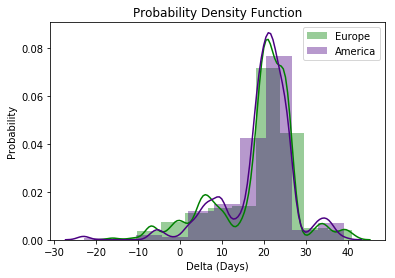

Ttest_indResult(statistic=-0.6393949534404058, pvalue=0.5227547302762833)


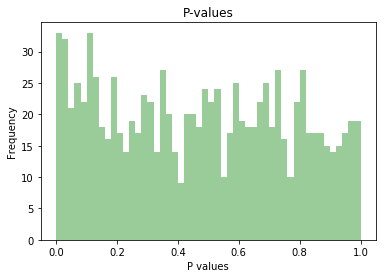

Mean p-value for all experiments: 0.47035647468843284


In [41]:
s1,s2,ps = tstats(europe,america,1000)
plotKDE(s1,s2,'Delta (Days)','Europe','America')
plotpval(ps)

##### Findings 5a: 
No significant difference between delivery time periods for shipments to Europe or America.

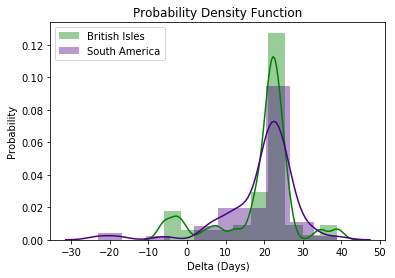

Ttest_indResult(statistic=-0.18551182178291495, pvalue=0.8530816080328198)


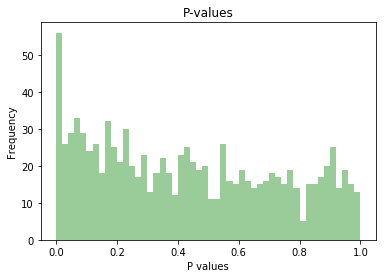

Mean p-value for all experiments: 0.43209023077637515


In [42]:
bri = df[df.Region=='British Isles'].Delta
sou = df[df.Region=='South America'].Delta

s1,s2,ps = tstats(bri,sou,1000)
plotKDE(s1,s2,'Delta (Days)','British Isles','South America')
plotpval(ps)

##### Findings 5b: 
No significant difference between delivery time periods for shipments to the British Isles or South America.

### Conclusion

After successfully exploring certain aspects of this dataset, we can find characteristics that flag it as fictional. For example, it is well-known that prices in Europe are higher than in America. This dataset, however, fails to show a statistically significant difference on various of the questions posed. 

We did find, however, that based on this data, not all discount levels are effective in encouraging bulk ordering.

### Future Work

It would be interesting to explore similar questions with a functional SQL database.


<img src="banner$.png">

<span style="color:indigo">Author: Valentina Fontiveros</span>